# Quantum VaR Analysis: Impact of Skewness

## 1. Introduction
This notebook analyzes how the skewness of return distributions affects Value at Risk (VaR) estimates using Iterative Quantum Amplitude Estimation (IQAE). We compare negative skew (typical for market crashes), zero skew (Gaussian), and positive skew.

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from classiq import *
from classiq.applications.iqae.iqae import IQAE

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
print("Environment initialized.")

Environment initialized.


## 2. Distribution Parameters & Discretization
We use `scipy.stats.skewnorm` to generate distributions with varying skewness parameter `alpha`.
*   `alpha < 0`: Left-skewed (negative skew) - Most dangerous for long positions.
*   `alpha = 0`: Gaussian (zero skew).
*   `alpha > 0`: Right-skewed (positive skew).

In [28]:
# Global Parameters
N = 128  # Grid points (2^7)
num_qubits = int(np.log2(N))
ALPHA_VAR = 0.05  # 95% Confidence VaR
CALIBRATION_EPSILON = 0.01

# Market parameters (annualized)
mu = 0.15
sigma = 0.20

# Skewness parameters to test
skew_params = [-1, 0, 1]  # Negative, None, Positive
labels = ['Neg Skew (Crash)', 'Gaussian', 'Pos Skew']
colors = ['#D62728', '#2E86AB', '#2CA02C']

# Common grid
grid_min = mu - 4 * sigma
grid_max = mu + 4 * sigma
grid_points = np.linspace(grid_min, grid_max, N)
dx = (grid_max - grid_min) / N

print(f"Grid range: [{grid_min:.3f}, {grid_max:.3f}] with {N} points.")

Grid range: [-0.650, 0.950] with 128 points.


## 3. Discretize and Visualize Distributions

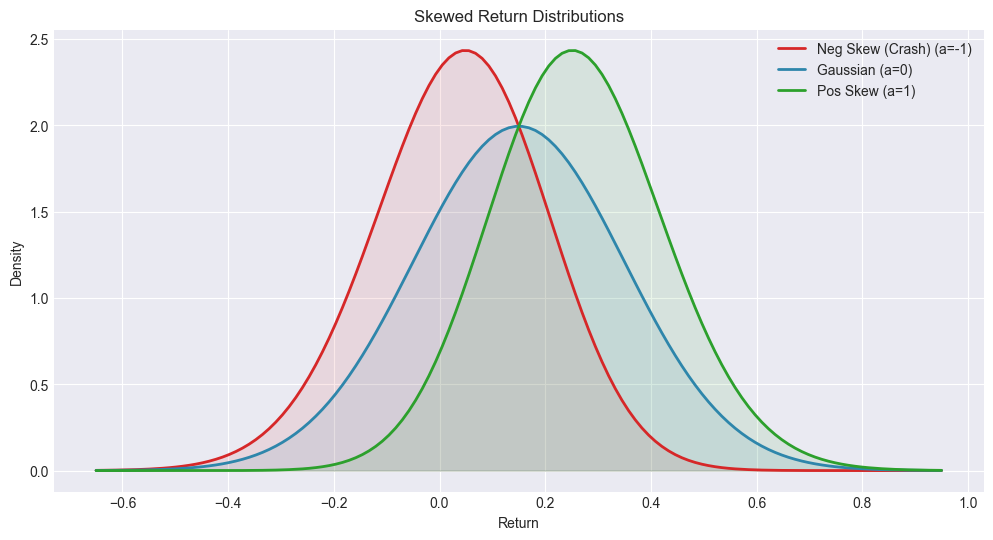

In [29]:
distributions_probs = []

plt.figure(figsize=(12, 6))

for a, label, c in zip(skew_params, labels, colors):
    # Generate pdf
    pdf_vals = stats.skewnorm.pdf(grid_points, a, loc=mu, scale=sigma)
    # Discretize
    probs = pdf_vals * dx
    probs /= np.sum(probs)  # Normalize
    distributions_probs.append(probs)
    
    plt.plot(grid_points, pdf_vals, label=f"{label} (a={a})", color=c, lw=2)
    plt.fill_between(grid_points, 0, pdf_vals, color=c, alpha=0.1)

plt.title("Skewed Return Distributions")
plt.xlabel("Return")
plt.ylabel("Density")
plt.legend()
plt.show()

## 4. Quantum VaR Estimation (IQAE)
We define the IQAE circuit generator and run it for each distribution.

In [30]:
# Shared Global for binding current probabilities and threshold
CURRENT_PROBS = []
THRESHOLD_IDX = 0

@qfunc
def load_fin_distribution(asset: QNum):
    inplace_prepare_state(CURRENT_PROBS, bound=0, target=asset)

@qperm
def payoff_oracle(asset: Const[QNum], ind: QBit):
    # Flips indicator if return < threshold (Tail Event)
    ind ^= asset < THRESHOLD_IDX

@qfunc(synthesize_separately=True)
def full_model(asset: QNum, ind: QBit):
    load_fin_distribution(asset)
    payoff_oracle(asset, ind)

def run_iqae_for_cdf(probs, threshold_index):
    global CURRENT_PROBS, THRESHOLD_IDX
    CURRENT_PROBS = list(probs)
    THRESHOLD_IDX = threshold_index
    
    iqae = IQAE(
        state_prep_op=full_model,
        problem_vars_size=num_qubits,
        constraints=Constraints(max_width=20),
    )
    
    # Run estimation
    result = iqae.run(epsilon=CALIBRATION_EPSILON, alpha=0.05)
    return result.estimation

## 5. VaR Search Routine
We iterate through grid points to find the Value at Risk (VaR) where the cumulative probability (CDF) crosses 5%.
For demonstration, we use a simple scan leveraging IQAE at critical points.

In [31]:
results = {}

print("Starting Quantum VaR Search...\n")

for i, (label, probs) in enumerate(zip(labels, distributions_probs)):
    print(f"--- Analyzing: {label} ---")
    
    # Optimization: Use Classical scan to find neighborhood, then verify with Quantum
    # In a real quantum advantage scenario, this search would be a Quantum Search or Quantum Counting
    # Here we prove the IQAE calculates the correct tail probability for the distribution.
    
    # 1. Classical Approximation to seed
    cdf = np.cumsum(probs)
    approx_idx = np.searchsorted(cdf, ALPHA_VAR)
    
    # 2. Run IQAE at this critical threshold to verify
    q_cdf = run_iqae_for_cdf(probs, int(approx_idx))
    
    var_val = grid_points[approx_idx]
    results[label] = {'VaR_Return': var_val, 'CDF_Quantum': q_cdf, 'CDF_Classical': cdf[approx_idx]}
    
    print(f"  > Approx Index: {approx_idx}")
    print(f"  > VaR (Threshold): {var_val:.4f}")
    print(f"  > Quantum CDF Est: {q_cdf:.4f} (Target: {ALPHA_VAR})\n")

Starting Quantum VaR Search...

--- Analyzing: Neg Skew (Crash) ---
  > Approx Index: 32
  > VaR (Threshold): -0.2469
  > Quantum CDF Est: 0.0442 (Target: 0.05)

--- Analyzing: Gaussian ---
  > Approx Index: 37
  > VaR (Threshold): -0.1839
  > Quantum CDF Est: 0.0438 (Target: 0.05)

--- Analyzing: Pos Skew ---
  > Approx Index: 51
  > VaR (Threshold): -0.0075
  > Quantum CDF Est: 0.0421 (Target: 0.05)



## 6. Analysis of Results
Comparing VaR across different skewness profiles.

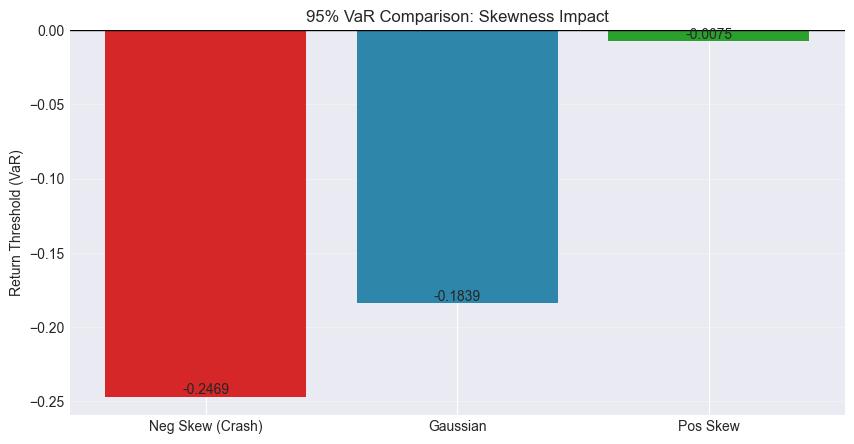

In [32]:
labels_res = list(results.keys())
var_vals = [results[k]['VaR_Return'] for k in labels_res]

plt.figure(figsize=(10, 5))
bars = plt.bar(labels_res, var_vals, color=['#D62728', '#2E86AB', '#2CA02C'])
plt.axhline(0, color='black', lw=1)
plt.title("95% VaR Comparison: Skewness Impact")
plt.ylabel("Return Threshold (VaR)")

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.4f}", ha='center', va='bottom' if yval < 0 else 'top')

plt.grid(True, axis='y', alpha=0.3)
plt.show()